# MMSegmentation Tutorial
Welcome to MMSegmentation! 

In this tutorial, we demo
* How to do inference with MMSeg trained weight
* How to train on your own dataset and visualize the results. 

## Install MMSegmentation
This step may take several minutes. 

We use PyTorch 1.10 and CUDA 11.1 for this tutorial. You may install other versions by change the version number in pip install command. 

In [1]:
# Check nvcc version
!nvcc -V
# Check GCC version
!gcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Sun_Feb_14_21:12:58_PST_2021
Cuda compilation tools, release 11.2, V11.2.152
Build cuda_11.2.r11.2/compiler.29618528_0
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [2]:

!pip3 install openmim
!mim install mmcv-full

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 50 kB 5.2 MB/s 
     |████████████████████████████████| 238 kB 55.2 MB/s 
     |████████████████████████████████| 51 kB 8.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.openmmlab.com/mmcv/dist/cu116/torch1.13.0/index.html
     |████████████████████████████████| 46.1 MB 1.7 MB/s 
     |████████████████████████████████| 190 kB 40.0 MB/s 


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/FYP_AD/maeseg

/content/drive/MyDrive/FYP_AD/maeseg


In [5]:
!rm -rf mmsegmentation
!git clone https://github.com/open-mmlab/mmsegmentation.git 
%cd mmsegmentation
!pip install -e .

Cloning into 'mmsegmentation'...
remote: Enumerating objects: 12906, done.
remote: Counting objects: 100% (115/115), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 12906 (delta 41), reused 73 (delta 33), pack-reused 12791
Receiving objects: 100% (12906/12906), 15.17 MiB | 9.46 MiB/s, done.
Resolving deltas: 100% (9307/9307), done.
Checking out files: 100% (1238/1238), done.
/content/drive/MyDrive/FYP_AD/maeseg/mmsegmentation
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Obtaining file:///content/drive/MyDrive/FYP_AD/maeseg/mmsegmentation
     |████████████████████████████████| 648 kB 28.7 MB/s 
  Running setup.py develop for mmsegmentation


In [6]:
%cd /content/drive/MyDrive/FYP_AD/maeseg/mmsegmentation

/content/drive/MyDrive/FYP_AD/maeseg/mmsegmentation


In [7]:
# Check Pytorch installation
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

# Check MMSegmentation installation
import mmseg
print(mmseg.__version__)

1.13.0+cu116 True
0.29.1


/usr/local/lib/python3.8/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


In [8]:
%cd /content/drive/MyDrive/FYP_AD/maeseg/mmsegmentation

/content/drive/MyDrive/FYP_AD/maeseg/mmsegmentation


## Run Inference with MMSeg trained weight

In [9]:

!python tools/model_converters/beit2mmseg.py https://dl.fbaipublicfiles.com/mae/pretrain/mae_pretrain_vit_base.pth  pretrain/mae_pretrain_vit_base_mmcls.pth

/usr/local/lib/python3.8/dist-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
load checkpoint from http path: https://dl.fbaipublicfiles.com/mae/pretrain/mae_pretrain_vit_base.pth
Downloading: "https://dl.fbaipublicfiles.com/mae/pretrain/mae_pretrain_vit_base.pth" to /root/.cache/torch/hub/checkpoints/mae_pretrain_vit_base.pth
100% 327M/327M [00:27<00:00, 12.5MB/s]


In [10]:
from mmseg.apis import inference_segmentor, init_segmentor, show_result_pyplot
from mmseg.core.evaluation import get_palette

## Train a semantic segmentation model on a new dataset

To train on a customized dataset, the following steps are necessary. 
1. Add a new dataset class. 
2. Create a config file accordingly. 
3. Perform training and evaluation. 

### Add a new dataset

Datasets in MMSegmentation require image and semantic segmentation maps to be placed in folders with the same prefix. To support a new dataset, we may need to modify the original file structure. 

In this tutorial, we give an example of converting the dataset. You may refer to [docs](https://github.com/open-mmlab/mmsegmentation/blob/master/docs/en/tutorials/customize_datasets.md#customize-datasets-by-reorganizing-data) for details about dataset reorganization. 

We use [Stanford Background Dataset](http://dags.stanford.edu/projects/scenedataset.html) as an example. The dataset contains 715 images chosen from existing public datasets [LabelMe](http://labelme.csail.mit.edu), [MSRC](http://research.microsoft.com/en-us/projects/objectclassrecognition), [PASCAL VOC](http://pascallin.ecs.soton.ac.uk/challenges/VOC) and [Geometric Context](http://www.cs.illinois.edu/homes/dhoiem/). Images from these datasets are mainly outdoor scenes, each containing approximately 320-by-240 pixels. 
In this tutorial, we use the region annotations as labels. There are 8 classes in total, i.e. sky, tree, road, grass, water, building, mountain, and foreground object. 

In [ ]:
# download and unzip
#!wget http://dags.stanford.edu/data/iccv09Data.tar.gz -O stanford_background.tar.gz
#!tar xf stanford_background.tar.gz

In [ ]:
import cv2 as cv
import glob
from PIL import Image as im
import numpy as np

#for p in glob.glob("/content/drive/MyDrive/FYP_AD/maeseg/fryum/train/good/*.JPG"):
#    im_array = np.zeros((cv.imread(p).shape))
#    data = im.fromarray(im_array.astype('uint8'))
#    data.save('/content/drive/MyDrive/FYP_AD/maeseg/fryum/labels1/{}'.format(p.split('/')[-1]))




In [ ]:
a = np.zeros((2,2,3))
a[:,:,0] = 255
a

array([[[255.,   0.,   0.],
        [255.,   0.,   0.]],

       [[255.,   0.,   0.],
        [255.,   0.,   0.]]])

In [15]:
"""
c
a1 = []
a2 = []
for i in g.glob("/content/drive/MyDrive/FYP_AD/maeseg/labels/*"):
    p = i.split('/')[-1]
    p = p.split('_')[0]
    os.rename(i, f'/content/drive/MyDrive/FYP_AD/maeseg/labels/{p}.png' )
for i in g.glob("/content/drive/MyDrive/FYP_AD/maeseg/fryum/train/bad/*"):
    p = i.split('/')[-1]
    p = int(p.split('.')[0])
    a2.append(p)
    """

'\nfor i in g.glob("/content/drive/MyDrive/FYP_AD/maeseg/fryum/train/bad/*"):\n    p = i.split(\'/\')[-1]\n    p = int(p.split(\'.\')[0])\n    a2.append(p)\n    '

In [19]:
import os 
import glob as g 



for i in g.glob("/content/drive/MyDrive/FYP_AD/maeseg/images/*"):
    p = i.split('/')[-1]
    p = p.split('.')[0]
    os.rename(i, f'/content/drive/MyDrive/FYP_AD/maeseg/images/{p}.JPG' )

In [ ]:
"""
from numpy import random
import numpy as np
import glob as g
import shutil 
import cv2 as cv 
from PIL import Image as im
arr = np.array([i for i in range(360)])
random.shuffle(arr)

i = 0
for p in g.glob('/content/drive/MyDrive/FYP_AD/maeseg/fryum/train/good/*'):
    shutil.copy(p, '/content/drive/MyDrive/FYP_AD/maeseg/fryum/images/{}.JPG'.format(f'{arr[i]:03d}'))
    im_array = np.zeros((cv.imread(p).shape))
    #im_array[:,:,0] = 255
    data = im.fromarray(im_array.astype('uint8'))
    data.save('/content/drive/MyDrive/FYP_AD/maeseg/fryum/labels/{}.png'.format(f'{arr[i]:03d}'))
    if i == 299:
        print('bad')
        for p1 in g.glob('/content/drive/MyDrive/FYP_AD/maeseg/fryum/train/bad/*'):
            rp = p1.split('/')[-1]
            rp = rp.split('.')[0]
            shutil.copy(p1, '/content/drive/MyDrive/FYP_AD/maeseg/fryum/images/{}.JPG'.format(f'{arr[i]:03d}'))
            image = cv.imread('/content/drive/MyDrive/FYP_AD/maeseg/fryum/ground_truth/train/bad/{}.png'.format(rp))
            image[np.where((image==[255,255,255]).all(axis=2))] = [0,0,255]
            cv.imwrite( '/content/drive/MyDrive/FYP_AD/maeseg/fryum/labels/{}.png'.format(f'{arr[i]:03d}'), image)
            i += 1
    else:
        i += 1 

"""
    

bad


In [18]:
import cv2 as cv
import glob as g
import numpy as np
for p1 in g.glob('/content/drive/MyDrive/FYP_AD/maeseg/labels/*'):
    #rp = p1.split('/')[-1]
    #rp = rp.split('.')[0]
    #shutil.copy(p1, '/content/drive/MyDrive/FYP_AD/maeseg/fryum/images/{}.JPG'.format(f'{arr[i]:03d}'))
    image = cv.imread(p1)
    image[np.where((image==[255,255,255]).all(axis=2))] = [0,0,255]
    cv.imwrite(p1, image)

In [ ]:
a = np.array([
    [0,0,0],
    [255,255,255]
])


In [ ]:
"""
import cv2 as cv 
import glob as g
import numpy as np

for p1 in g.glob('/content/drive/MyDrive/FYP_AD/maeseg/fryum/ground_truth/train/bad/*.png'):
    im = cv.imread(p1)
    print(np.unique(im))
    
    break
    """


[  0 255]


In [26]:

from numpy import random
import numpy as np
import glob as g
import shutil 
import cv2 as cv 
from PIL import Image as im

for p in g.glob('/content/drive/MyDrive/FYP_AD/maeses/images/*'):
    im = cv.imread(p)
    im = cv.resize(im, (1000, 1500))
    cv.imwrite(p, im)


for p in g.glob('/content/drive/MyDrive/FYP_AD/maeseg/labels/*'):
    im = cv.imread(p)
    im = cv.resize(im, (1000, 1500))
    cv.imwrite(p, im)



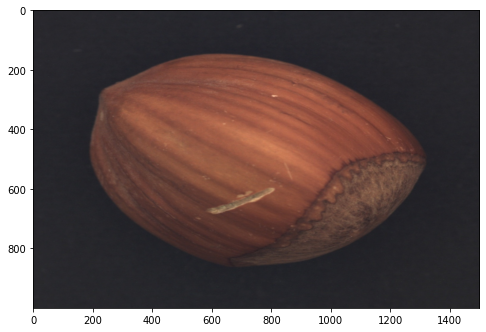

In [28]:
# Let's take a look at the dataset
import mmcv
import matplotlib.pyplot as plt

img = mmcv.imread('/content/drive/MyDrive/FYP_AD/maeseg/images/000.JPG')
plt.figure(figsize=(8, 6))
plt.imshow(mmcv.bgr2rgb(img))
plt.show()

We need to convert the annotation into semantic map format as an image.

In [21]:
import os.path as osp
import numpy as np
from PIL import Image
# convert dataset annotation to semantic segmentation map
data_root = '/content/drive/MyDrive/FYP_AD/maeseg'
img_dir = 'images'
ann_dir = 'labels'
# define class and plaette for better visualization
classes = ('bg' , 'ar')
palette = [[0,0,0],[255,0,0]]

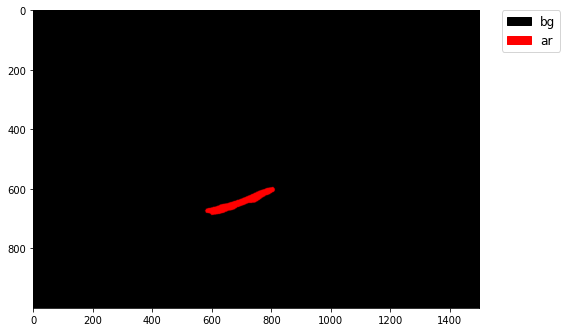

In [22]:
# Let's take a look at the segmentation map we got
import matplotlib.patches as mpatches
img = Image.open('/content/drive/MyDrive/FYP_AD/maeseg/labels/000.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

# create a patch (proxy artist) for every color 
patches = [mpatches.Patch(color=np.array(palette[i])/255., 
                          label=classes[i]) for i in range(2)]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., 
           fontsize='large')

plt.show()

In [23]:
# split train/val set randomly

split_dir = 'splits'
mmcv.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmcv.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]
with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 4/5 as train set
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])
with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])
  

After downloading the data, we need to implement `load_annotations` function in the new dataset class `StanfordBackgroundDataset`.

In [24]:
from mmseg.datasets.builder import DATASETS
from mmseg.datasets.custom import CustomDataset

@DATASETS.register_module()
class VisA(CustomDataset):
  CLASSES = classes
  PALETTE = palette
  def __init__(self, split,**kwargs):
    super().__init__(img_suffix='.JPG', seg_map_suffix='.png', 
                     split=split, reduce_zero_label=False, **kwargs)
    assert osp.exists(self.img_dir) and self.split is not None


    

### Create a config file
In the next step, we need to modify the config for the training. To accelerate the process, we finetune the model from trained weights.

In [25]:
from mmcv import Config
cfg = Config.fromfile('configs/mae/upernet_mae-base_fp16_8x2_512x512_160k_ade20k.py')
#cfg = Configs.fromfile('configs/mae/upernet_mae-base_fp16_512x512_160k_ade20k_ms.py')

In [ ]:
%cd /content

/content


Since the given config is used to train PSPNet on the cityscapes dataset, we need to modify it accordingly for our new dataset.  

In [ ]:
from mmseg.apis import set_random_seed
from mmseg.utils import get_device

# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
#cfg.norm_cfg1 = dict(type='BN', eps=1e-06)
#cfg.model.backbone.norm_cfg = cfg.norm_cfg1
cfg.model.neck.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head

cfg.model.decode_head.num_classes = 2
cfg.model.auxiliary_head.num_classes = 2

# Modify dataset type and path
cfg.dataset_type = 'VisA'
cfg.data_root = data_root

cfg.data.samples_per_gpu = 4
cfg.data.workers_per_gpu= 4

cfg.img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.crop_size = (512, 512)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', img_scale=(1500, 1000), ratio_range=(0.5, 1)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    #dict(type='CenterCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **cfg.img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1500,1000),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **cfg.img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]


cfg.data.train.type = cfg.dataset_type
cfg.data.train.data_root = cfg.data_root
cfg.data.train.img_dir = img_dir
cfg.data.train.ann_dir = ann_dir
cfg.data.train.pipeline = cfg.train_pipeline
cfg.data.train.split = '/content/drive/MyDrive/FYP_AD/maeseg/splits/train.txt'

cfg.data.val.type = cfg.dataset_type
cfg.data.val.data_root = cfg.data_root
cfg.data.val.img_dir = img_dir
cfg.data.val.ann_dir = ann_dir
cfg.data.val.pipeline = cfg.test_pipeline
cfg.data.val.split = '/content/drive/MyDrive/FYP_AD/maeseg/splits/val.txt'

cfg.data.test.type = cfg.dataset_type
cfg.data.test.data_root = cfg.data_root
cfg.data.test.img_dir = img_dir
cfg.data.test.ann_dir = ann_dir
cfg.data.test.pipeline = cfg.test_pipeline
cfg.data.test.split = '/content/drive/MyDrive/FYP_AD/maeseg/splits/val.txt'

# We can still use the pre-trained Mask RCNN model though we do not need to
# use the mask branch
cfg.load_from = '/content/drive/MyDrive/FYP_AD/maeseg/mmsegmentation/pretrain/mae_pretrain_vit_base_mmcls.pth'

# Set up working dir to save files and logs.
cfg.work_dir = '/content/drive/MyDrive/FYP_AD/maeseg/mmsegmentation/work_dirs/tutorial3'

cfg.runner.max_iters = 20000
cfg.log_config.interval = 200
cfg.evaluation.interval = 500
cfg.checkpoint_config.interval = 500
cfg.evaluation.save_best='mIoU'
cfg.checkpoint_config.max_ckpts = 2


# Set seed to facitate reproducing the result
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)
cfg.device = get_device()

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
norm_cfg = dict(type='BN', requires_grad=True)
model = dict(
    type='EncoderDecoder',
    pretrained='./pretrain/mae_pretrain_vit_base_mmcls.pth',
    backbone=dict(
        type='MAE',
        img_size=(512, 512),
        patch_size=16,
        in_channels=3,
        embed_dims=768,
        num_layers=12,
        num_heads=12,
        mlp_ratio=4,
        out_indices=[3, 5, 7, 11],
        attn_drop_rate=0.0,
        drop_path_rate=0.1,
        norm_cfg=dict(type='LN', eps=1e-06),
        act_cfg=dict(type='GELU'),
        norm_eval=False,
        init_values=1.0),
    neck=dict(
        type='Feature2Pyramid',
        embed_dim=768,
        rescales=[4, 2, 1, 0.5],
        norm_cfg=dict(type='BN', requires_grad=True)),
    decode_head=dict(
        type='UPerHead',
        in_channels=[768, 768, 768, 768],
        in_index=[0, 1, 2, 3],
        pool_scales=(1, 2, 3, 6),
        channels=768,
        dropout_ratio=0.1,
        num_classes=2,
        norm_cfg=dict(type='BN', 

### Train and Evaluation

In [ ]:
from mmseg.datasets import build_dataset
from mmseg.models import build_segmentor
from mmseg.apis import train_segmentor


# Build the dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_segmentor(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_segmentor(model, datasets, cfg, distributed=False, validate=True, 
                meta=dict())

2022-12-29 05:05:31,964 - mmseg - INFO - Loaded 288 images
/content/drive/MyDrive/FYP_AD/maeseg/mmsegmentation/mmseg/models/backbones/beit.py:303: UserWarning: DeprecationWarning: pretrained is deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is deprecated, '
/usr/local/lib/python3.8/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/content/drive/MyDrive/FYP_AD/maeseg/mmsegmentation/mmseg/models/decode_heads/decode_head.py:94: UserWarning: For binary segmentation, we suggest using`out_channels = 1` to define the outputchannels of segmentor, and use `threshold`to convert seg_logist into a predictionapplying a threshold
  warnings.warn('For binary segmentation, we suggest using'
/content/drive/MyDrive/FYP_AD/maeseg

ValueError: ignored

Inference with trained model

/content/drive/MyDrive/FYP_AD/maeseg/mmsegmentation/mmseg/models/segmentors/base.py:289: UserWarning: show==False and out_file is not specified, only result image will be returned
  warnings.warn('show==False and out_file is not specified, only '


<Figure size 576x432 with 0 Axes>

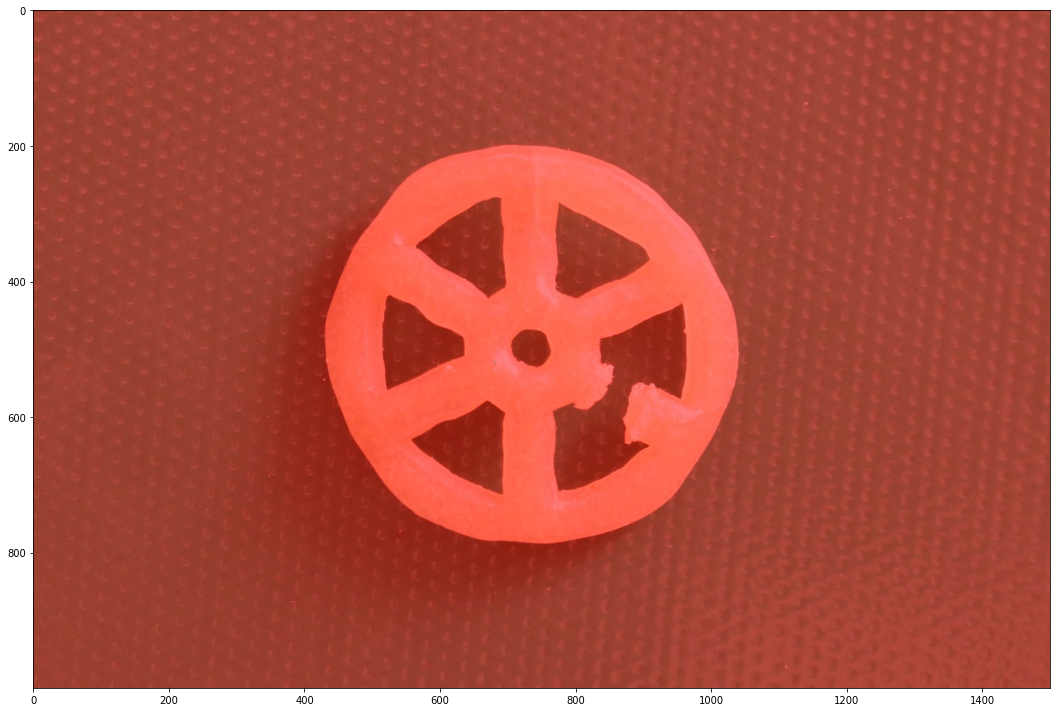

In [ ]:
img = mmcv.imread('/content/drive/MyDrive/FYP_AD/maeseg/capsules/images/078.JPG')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

In [ ]:
import cv2 as cv

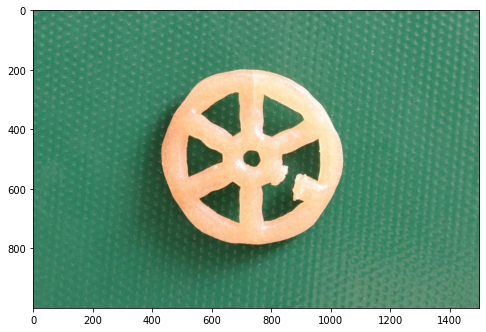

In [ ]:
img = Image.open('/content/drive/MyDrive/FYP_AD/maeseg/capsules/images/078.JPG')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img))

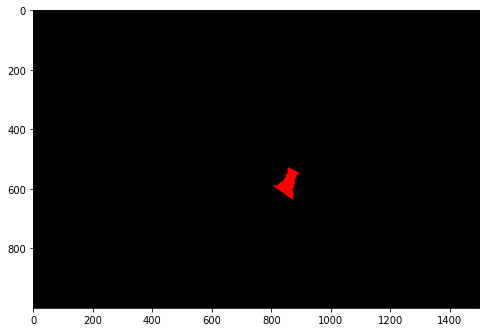

In [ ]:
img = Image.open('/content/drive/MyDrive/FYP_AD/maeseg/capsules/labels/078.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

<Figure size 576x432 with 0 Axes>

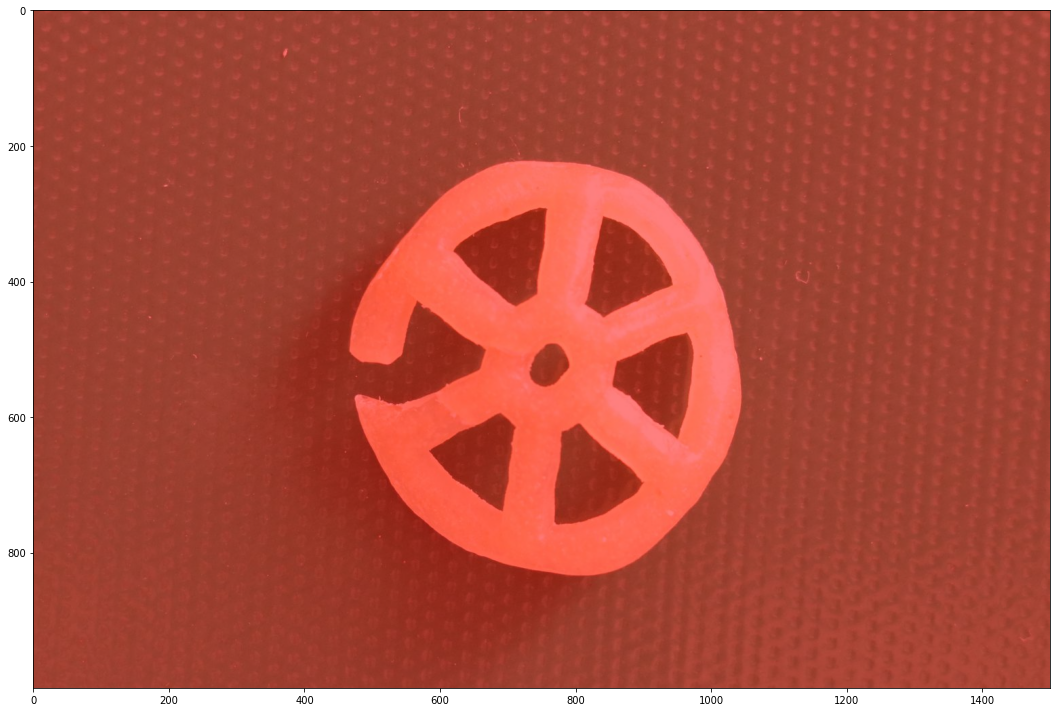

In [ ]:
img = mmcv.imread('/content/drive/MyDrive/FYP_AD/maeseg/capsules/images/011.JPG')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

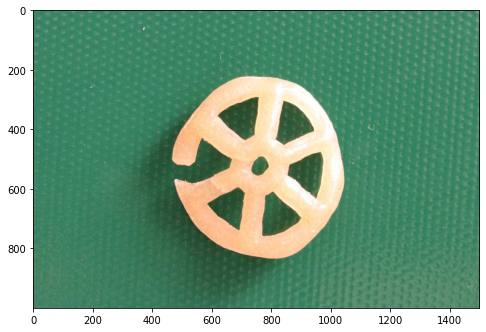

In [ ]:
img = Image.open('/content/drive/MyDrive/FYP_AD/maeseg/capsules/images/011.JPG')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img))

<Figure size 576x432 with 0 Axes>

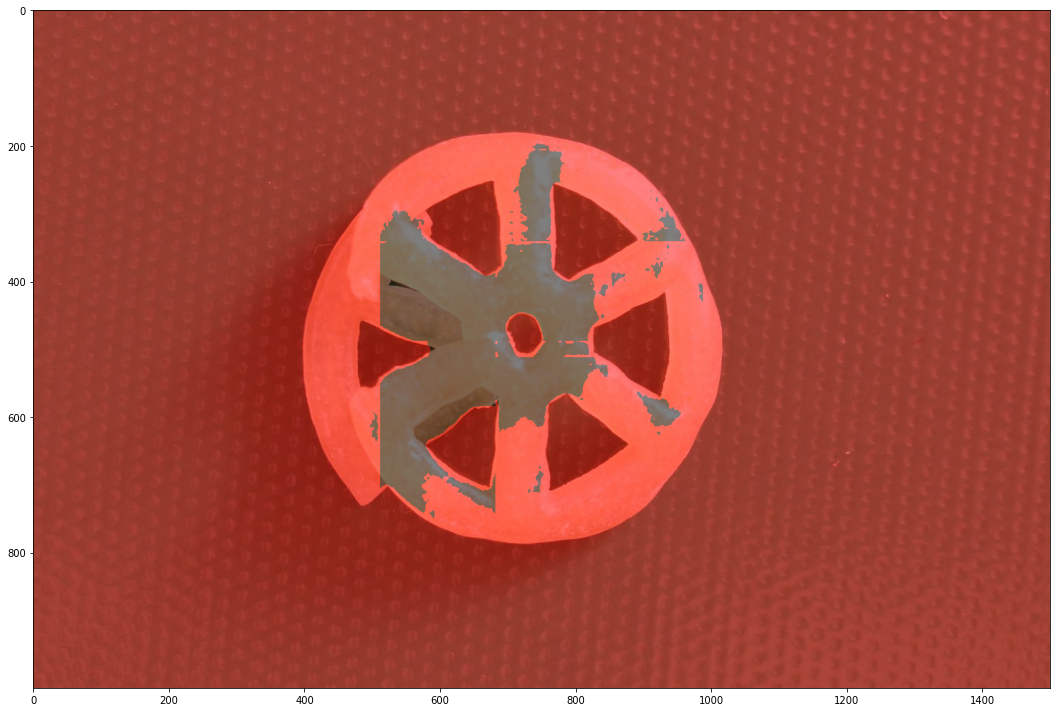

In [ ]:
img = mmcv.imread('/content/drive/MyDrive/FYP_AD/maeseg/capsules/images/046.JPG')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

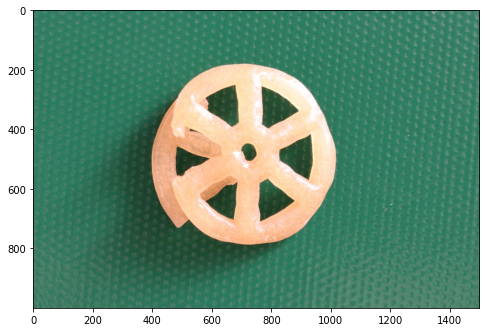

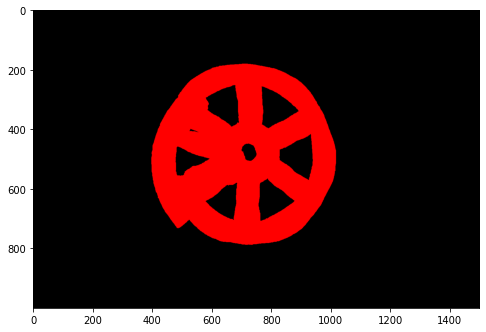

In [ ]:
img = Image.open('/content/drive/MyDrive/FYP_AD/maeseg/capsules/images/046.JPG')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img))

img = Image.open('/content/drive/MyDrive/FYP_AD/maeseg/capsules/labels/046.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

<Figure size 576x432 with 0 Axes>

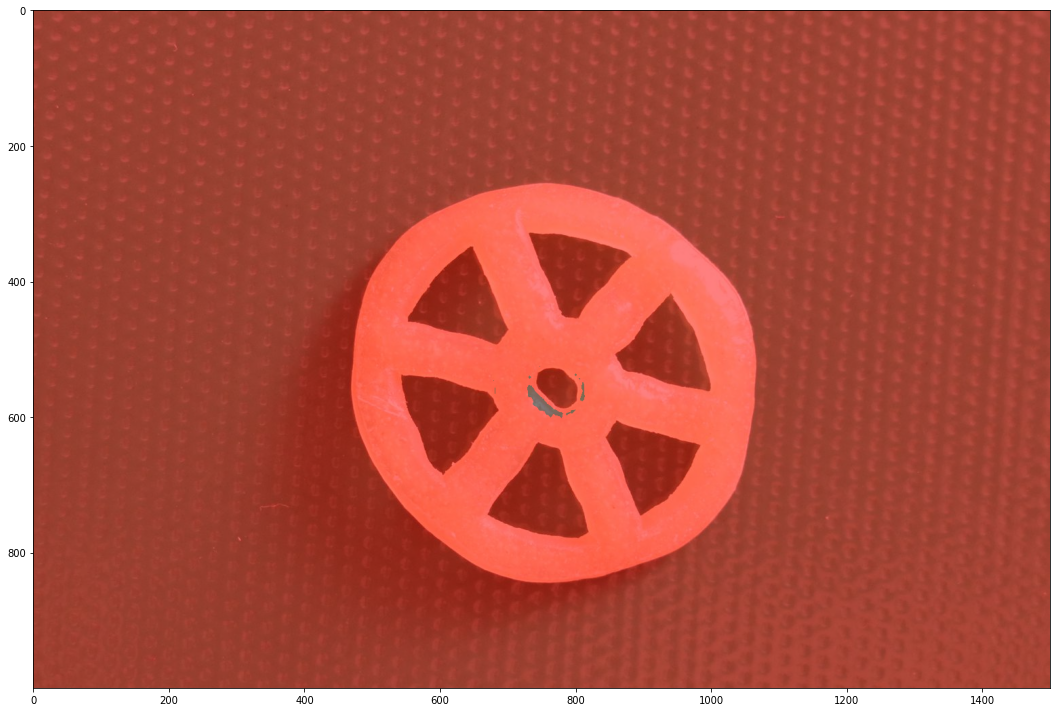

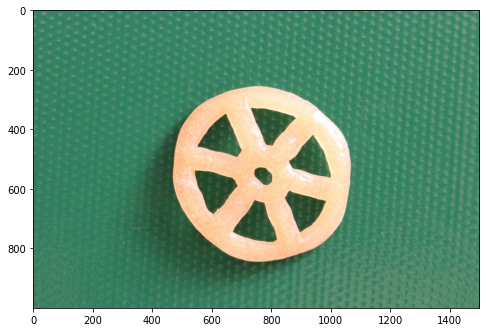

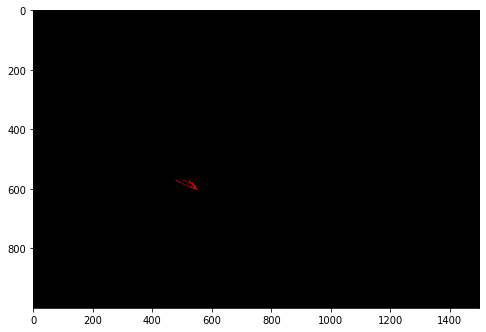

In [ ]:
img = mmcv.imread('/content/drive/MyDrive/FYP_AD/maeseg/capsules/images/090.JPG')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

img = Image.open('/content/drive/MyDrive/FYP_AD/maeseg/capsules/images/090.JPG')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img))

img = Image.open('/content/drive/MyDrive/FYP_AD/maeseg/capsules/labels/090.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))

<Figure size 576x432 with 0 Axes>

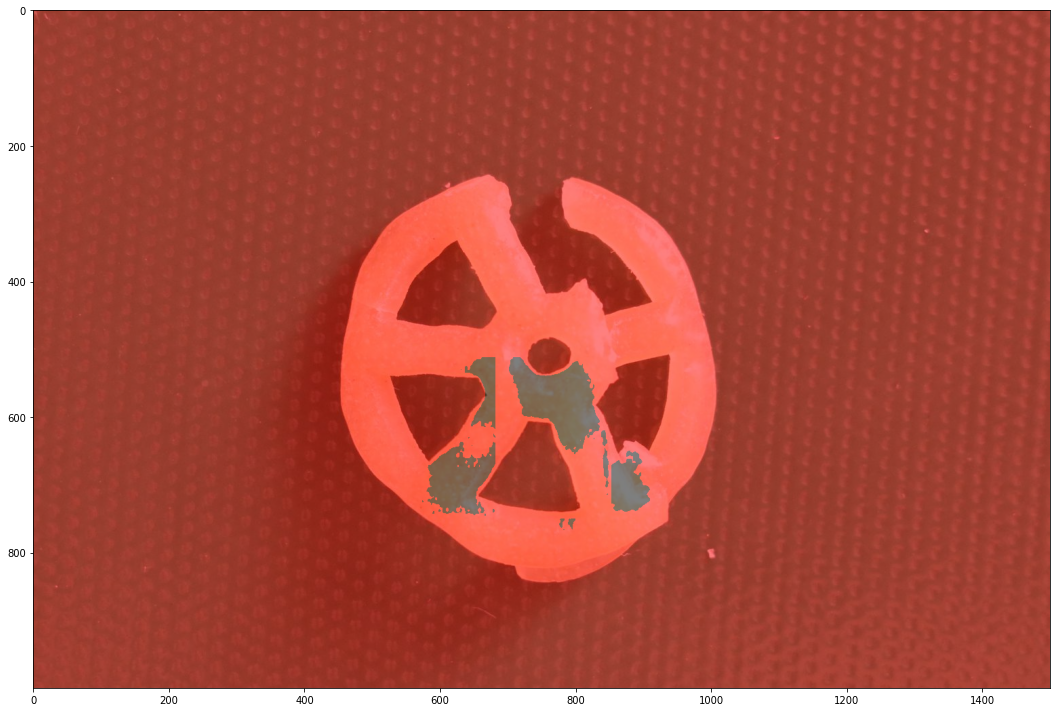

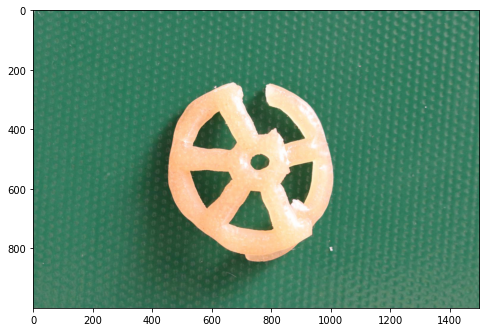

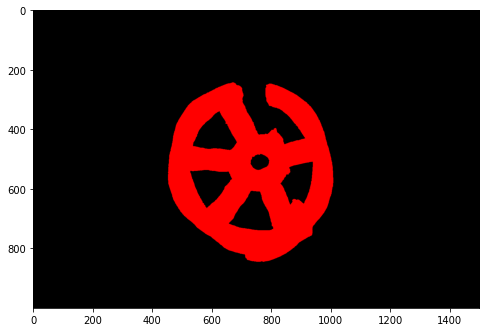

In [ ]:
img = mmcv.imread('/content/drive/MyDrive/FYP_AD/maeseg/capsules/images/051.JPG')

model.cfg = cfg
result = inference_segmentor(model, img)
plt.figure(figsize=(8, 6))
show_result_pyplot(model, img, result, palette)

img = Image.open('/content/drive/MyDrive/FYP_AD/maeseg/capsules/images/051.JPG')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img))

img = Image.open('/content/drive/MyDrive/FYP_AD/maeseg/capsules/labels/051.png')
plt.figure(figsize=(8, 6))
im = plt.imshow(np.array(img.convert('RGB')))